In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

##Load Data

In [2]:
user = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/Engagement_Test/user_table.csv', 
                   parse_dates=['signup_date'])
user.head()

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [4]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
user_id        100000 non-null int64
signup_date    100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.5 MB


In [5]:
test = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/Engagement_Test/test_table.csv', 
                   parse_dates=['date'])
test.head()

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
user_id          100000 non-null int64
date             100000 non-null datetime64[ns]
browser          100000 non-null object
test             100000 non-null int64
pages_visited    100000 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.8+ MB


In [7]:
# join user and test table
data = pd.merge(left=user, right=test, on='user_id', how='left')
data.head()

,user_id,signup_date,date,browser,test,pages_visited
0,34,2015-01-01,2015-08-15,Chrome,0,6
1,59,2015-01-01,2015-08-12,Chrome,1,6
2,178,2015-01-01,2015-08-10,Safari,1,3
3,285,2015-01-01,2015-08-03,Opera,0,5
4,383,2015-01-01,2015-08-05,Firefox,1,9


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
user_id          100000 non-null int64
signup_date      100000 non-null datetime64[ns]
date             100000 non-null datetime64[ns]
browser          100000 non-null object
test             100000 non-null int64
pages_visited    100000 non-null int64
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 5.3+ MB


###Question 1

Is the test winning? That is, should 100% of the users see the Recommended Friends feature?

In [9]:
data.groupby('test')['pages_visited'].mean()

test
0    4.608394
1    4.599693
Name: pages_visited, dtype: float64

In [10]:
# perform t-test
control_page = data[data['test'] == 0]['pages_visited'].values
experiment_page = data[data['test'] == 1]['pages_visited'].values

print('T-test:\t', ttest_ind(a=control_page, b=experiment_page, equal_var=False))

T-test:	 Ttest_indResult(statistic=0.5571118435554797, pvalue=0.5774523171559118)


T-test:	 Ttest_indResult(statistic=0.5571118435554797, pvalue=0.5774523171559118)
From above analysis, we can find that p-value is 0.577, which is much larger than 5%, so we cannot reject the null hypothesis that there is no difference between control and experiment group.

So, the test doesn't win at tall. This shouldn't expand to all users.

###Question 2

Is the test performing similarly for all user segments or are there differences among different segments?

In [11]:
# process the data
data['interval'] = (data['date'] - data['signup_date']).apply(lambda x: x.days)
data['is_first'] = (data['interval'] == 0).astype(int)

data.head()

,user_id,signup_date,date,browser,test,pages_visited,interval,is_first
0,34,2015-01-01,2015-08-15,Chrome,0,6,226,0
1,59,2015-01-01,2015-08-12,Chrome,1,6,223,0
2,178,2015-01-01,2015-08-10,Safari,1,3,221,0
3,285,2015-01-01,2015-08-03,Opera,0,5,214,0
4,383,2015-01-01,2015-08-05,Firefox,1,9,216,0


####Impact by Browser

C:\Users\siyue\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


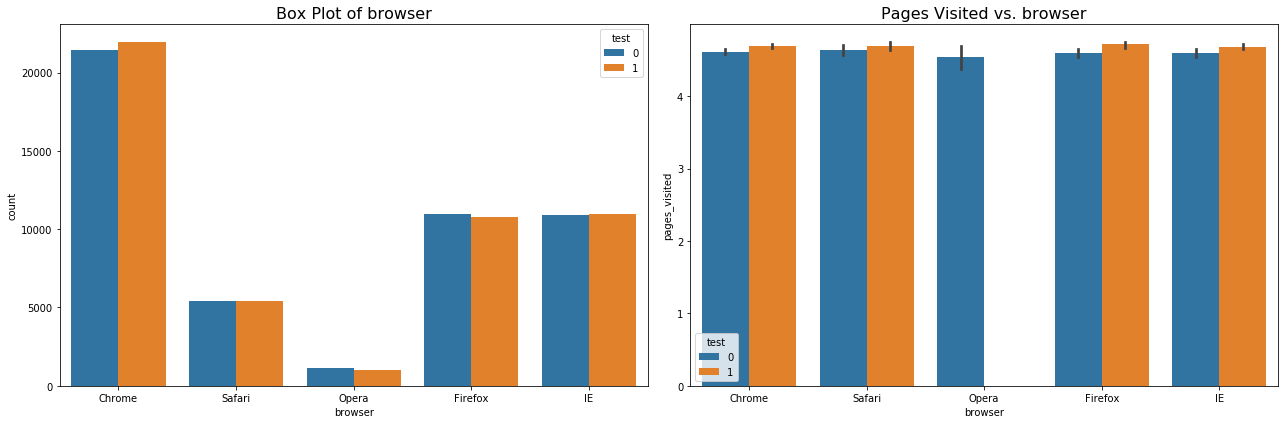

In [12]:
# visualization of browser
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=data, ax=ax[0])
ax[0].set_title('Box Plot of browser', fontsize=16)

sns.barplot(x='browser', y='pages_visited', hue='test', data=data, ax=ax[1])
ax[1].set_title('Pages Visited vs. browser', fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
def run_ttest(df):
    vp_in_test = df.loc[data.test == 1, 'pages_visited']
    test_mean = vp_in_test.mean()
    
    vp_in_ctrl = df.loc[data.test == 0, 'pages_visited']
    ctrl_mean = vp_in_ctrl.mean()
    
    result = ttest_ind(vp_in_ctrl, vp_in_test, equal_var=False)
    conclusion = 'Significant' if result.pvalue < 0.05 else 'Not Significant'
    
    return pd.Series({'n_test':vp_in_test.shape[0],
                      'n_ctrl': vp_in_ctrl.shape[0],
                      'mean_test': test_mean,
                      'mean_ctrl': ctrl_mean,
                      'test-ctrl': test_mean - ctrl_mean,
                      'pvalue':result.pvalue,
                      'conclusion':conclusion})

In [16]:
data.groupby('browser').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
browser,,,,,,,
Chrome,21974,21453,4.690680,4.613341,0.077339,9.434084e-04,Significant
Firefox,10786,10972,4.714259,4.600164,0.114095,5.817199e-04,Significant
IE,10974,10906,4.685985,4.598478,0.087507,7.829509e-03,Significant
Opera,1018,1109,0.000000,4.546438,-4.546438,2.252939e-321,Significant
Safari,5402,5406,4.692336,4.638180,0.054156,2.411738e-01,Not Significant


From result above, we can see that, by applying this "Recommend Friend" feature

page_visited in Chrome, Firefox, IE are significantly increased.
page_visited in Opera has reduced to zero, maybe there is some bug in implementation on Opera, which stops user visiting further pages.
page_visited in Safari has no significant improvement, maybe because the recommended friends aren't shown in a noticeable position.

####Impact by old user and new user

C:\Users\siyue\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


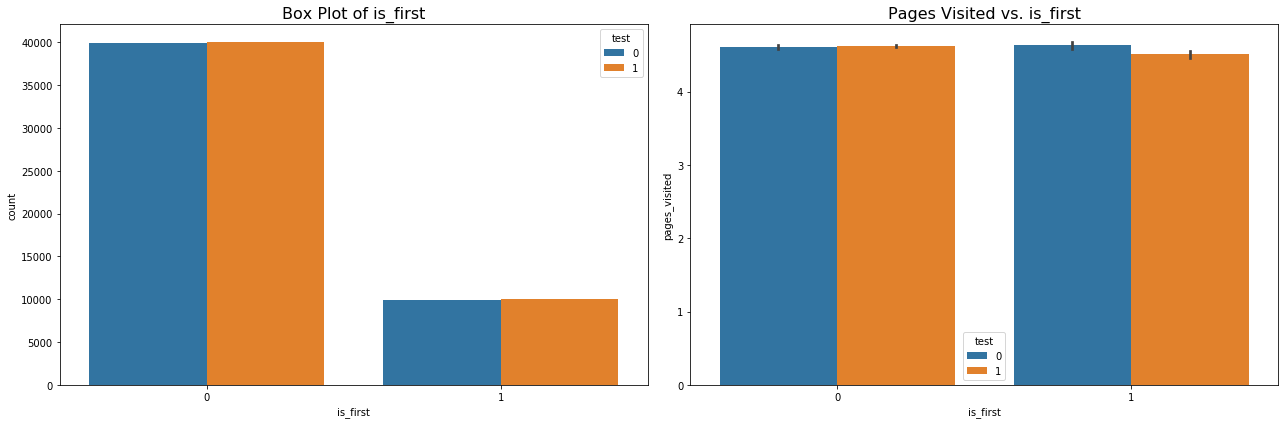

In [17]:
# visualization of is_first
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='is_first', hue='test', data=data, ax=ax[0])
ax[0].set_title('Box Plot of is_first', fontsize=16)

sns.barplot(x='is_first', y='pages_visited', hue='test', data=data, ax=ax[1])
ax[1].set_title('Pages Visited vs. is_first', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
data.groupby('is_first').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
is_first,,,,,,,
0,40109,39890,4.622379,4.603284,0.019095,0.261837,Not Significant
1,10045,9956,4.509109,4.628867,-0.119758,0.001742,Significant


Above result shows:

For old users, the new feature improve #page_visted, but the change isn't significant
For first-time new users, this new feature significantly decrease #page_visited .

This is a strange observation. Since I already suspect there is some bug in Opera's implementation (which reduce the visited number to 0 after using this new feature), so I need to split the dataset further by browser.

###Question 3

After identifing segments that responded differently to the test, what might be the possible reasons? Would this change conclusions made in question 1?

From the visualization in above part, we can see that the number of pages visited is increased for some factors, such as Chrome, Safari, Firefox, and IE, but the number of pages visited is always 0 for Opera, which shows that there might be some errors or bugs.

If user visit the website right after they signup, the number of pages visited actually get decreased when they are exposed to the new feature.

Now, let's remove the user who use Opera, and conduct t-test again.

In [20]:
subset = data[data['browser'] != 'Opera']
subset.groupby('test')['pages_visited'].mean()

test
0    4.609804
1    4.694989
Name: pages_visited, dtype: float64

C:\Users\siyue\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


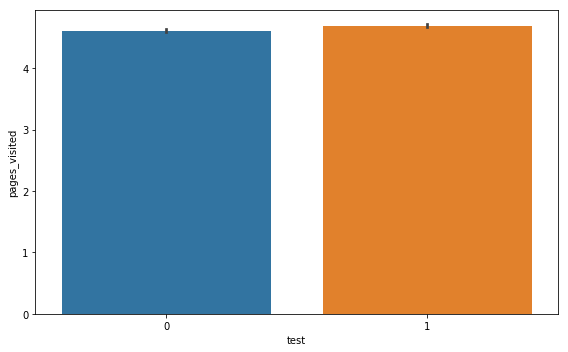

In [21]:
# visualization
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='test', y='pages_visited', data=subset, ax=ax)
plt.tight_layout()
plt.show()

In [22]:
# perform t-test
control_page = subset[subset['test'] == 0]['pages_visited'].values
experiment_page = subset[subset['test'] == 1]['pages_visited'].values

print('T-test:\t', ttest_ind(a=control_page, b=experiment_page, equal_var=False))

T-test:	 Ttest_indResult(statistic=-5.474295518566027, pvalue=4.403954129457701e-08)


So, it's clear that after removing the records with Opera browser, the new feature becomes significantly useful. So, I would suggest expanding this feature to other users.

C:\Users\siyue\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


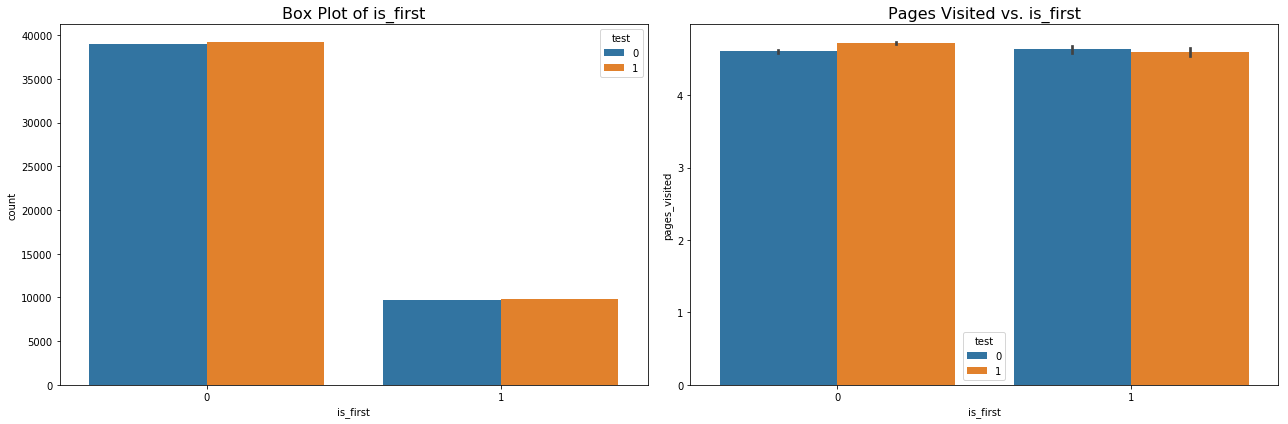

In [23]:
# visualization of is_first
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='is_first', hue='test', data=subset, ax=ax[0])
ax[0].set_title('Box Plot of is_first', fontsize=16)

sns.barplot(x='is_first', y='pages_visited', hue='test', data=subset, ax=ax[1])
ax[1].set_title('Pages Visited vs. is_first', fontsize=16)
plt.tight_layout()
plt.show()

In [24]:
subset.groupby('is_first').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
is_first,,,,,,,
0,39276,39007,4.720415,4.603481,0.116933,4.859482e-12,Significant
1,9860,9730,4.593712,4.635149,-0.041437,2.797387e-01,Not Significant


After removing records with Opera browser, for old users, the new feature improve #page_visted, and the change is significant;
for first-time new users, this new feature decreases #page_visited but the change is not significant.

In [26]:
# impact by browser and user type
ttest_result = subset.groupby(['browser','is_first']).apply(run_ttest)

# impact on old users by browser after removing 'Opera' browser records
ttest_result.xs(0,level=1)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
browser,,,,,,,
Chrome,17525,17092,4.701512,4.607945,0.093567,0.000229,Significant
Firefox,8657,8842,4.757306,4.590590,0.166716,0.000004,Significant
IE,8779,8744,4.721494,4.590576,0.130918,0.000267,Significant
Safari,4315,4329,4.720973,4.638254,0.082720,0.100083,Not Significant


For old users, the conclusion is the same as general 'browser impact', which is:

#page_visited in Chrome, Firefox, IE are significantly increased.
#page_visited in Safari has no significant improvement, maybe because the recommended friends aren't shown in a noticeable position.

In [27]:
# impact on old users by browser after removing 'Opera' browser records
ttest_result.xs(1,level=1)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
browser,,,,,,,
Chrome,4449,4361,4.648011,4.634488,0.013523,0.814918,Not Significant
Firefox,2129,2130,4.539220,4.639906,-0.100686,0.221071,Not Significant
IE,2195,2162,4.543964,4.630435,-0.086471,0.280842,Not Significant
Safari,1087,1077,4.578657,4.637883,-0.059226,0.601524,Not Significant


After removing 'Opera', all changes for new users are not significant, and there is even some drop after applying this new feature.

This may because: the friend recommendation engine may be based on a user's previous social activity on the site. then for new users, since they don't have any previous history for recommendation engine to use, the recommendation result is like random guess, which cannot draw new user's interest. But the recommended friends may occupy some space on the page, so it may even decrease the #page_visited for new users a little bit.

From this observation, I suspect the Recommedation Engine suffers 'the cold start' problem.